🎉 Goal reached at step 20!


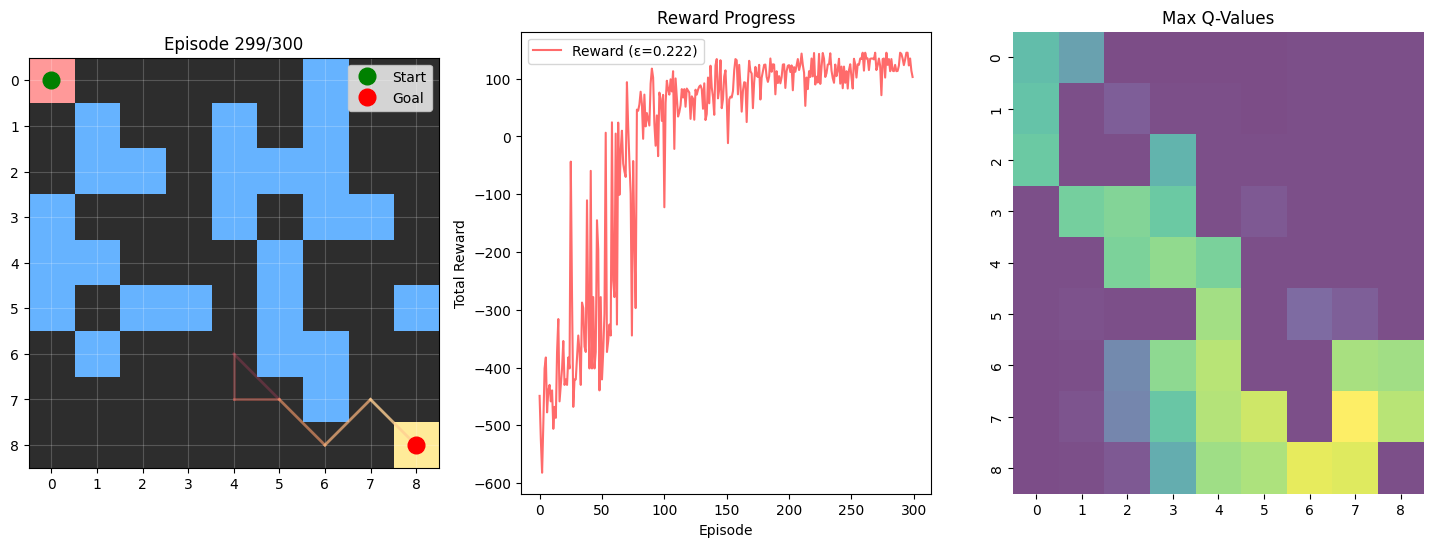

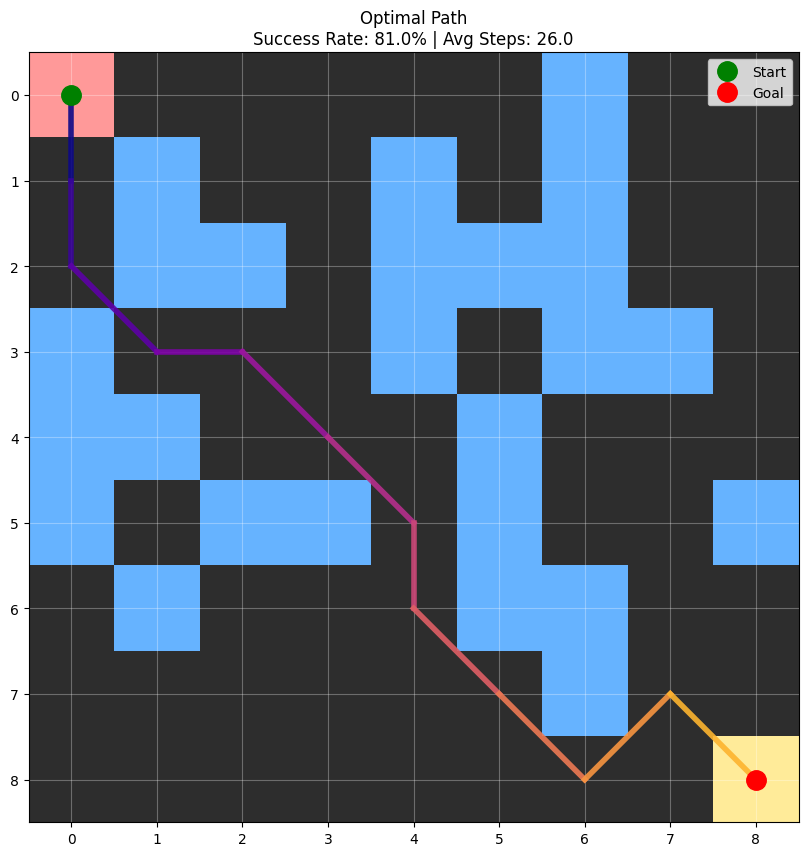

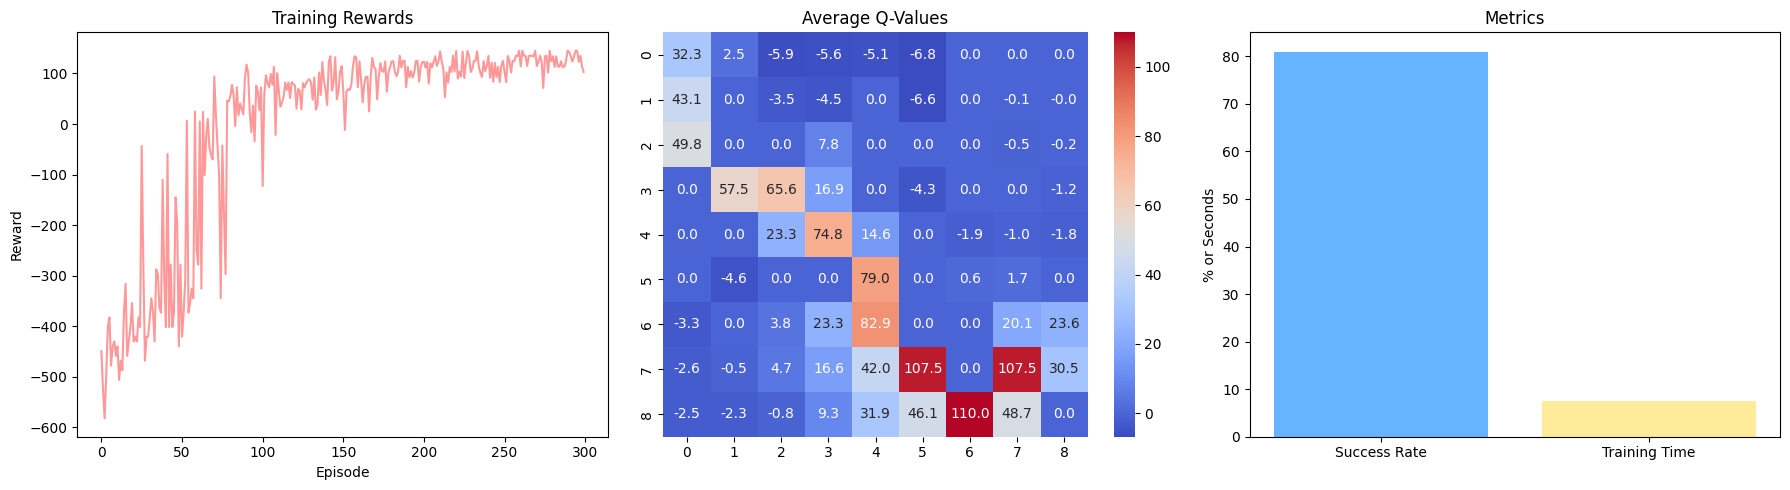

🏆 Training Summary: Success Rate: 81.0%, Avg Path Length: 26.0, Time: 7.4s
🎉 Training completed!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from IPython.display import display, clear_output, HTML
import time

# Custom colormap for maze
colors = ['#2d2d2d', '#66b3ff', '#ff9999', '#ffeb99']  # Wall, Path, Start, Goal
cm = LinearSegmentedColormap.from_list("maze_cmap", colors, N=4)

class CreativeMazeSolver:
    def __init__(self, size=7, wall_density=0.3, maze_type="random"):
        """Initialize with a maze (random or predefined)"""
        self.size = size
        self.wall_density = wall_density
        self.maze_type = maze_type
        self.maze = self.generate_maze()
        self.q_table = np.zeros((size, size, 8))  # 8 actions (including diagonals)
        self.actions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.exploration_rate = 1.0
        self.min_exploration = 0.01
        self.decay_rate = 0.995
        self.history = []
        self.success_count = 0
        self.path_lengths = []
        self.start_time = None
        # Initialize figure and axes
        self.fig, self.axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1]})
        plt.ion()  # Interactive mode

    def generate_maze(self):
        """Generate a maze based on type"""
        if self.maze_type == "random":
            maze = np.random.choice([0, 1], size=(self.size, self.size), p=[1-self.wall_density, self.wall_density])
            maze[0, 0] = 2  # Start
            maze[self.size-1, self.size-1] = 3  # Goal
            maze[0, 1] = maze[1, 0] = maze[self.size-2, self.size-1] = maze[self.size-1, self.size-2] = 0
        else:  # Predefined challenging maze
            maze = np.ones((self.size, self.size))
            maze[0, 0] = 2
            maze[self.size-1, self.size-1] = 3
            for i in range(self.size):
                maze[i, i % 2::2] = 0  # Create a zigzag path
            maze[self.size-2, self.size-1] = 0
        return maze

    def is_valid(self, state):
        """Check if state is valid"""
        r, c = state
        return 0 <= r < self.size and 0 <= c < self.size and self.maze[r, c] != 1

    def step(self, state, action):
        """Take a step with enhanced rewards"""
        r, c = state
        dr, dc = self.actions[action]
        next_state = (r + dr, c + dc)
        if not self.is_valid(next_state):
            return state, -10, False  # Increased penalty for walls
        if self.maze[next_state] == 3:
            print(f"🎉 Goal reached at step {len(self.history[-1]) if self.history else 0}!")
            return next_state, 150, True  # Higher reward for goal
        return next_state, -0.5, False  # Small penalty to encourage efficiency

    def choose_action(self, state):
        """Epsilon-greedy action selection with noise"""
        if np.random.random() < self.exploration_rate:
            return np.random.randint(8)
        q_values = self.q_table[state[0], state[1]] + np.random.normal(0, 0.01, 8)  # Add noise for exploration
        return np.argmax(q_values)

    def train(self, episodes=200, update_freq=10):
        """Train with enhanced visualization and metrics"""
        start = (0, 0)
        goal = (self.size-1, self.size-1)
        rewards = []
        self.start_time = time.time()

        for episode in range(episodes):
            state = start
            path = [state]
            total_reward = 0
            done = False
            steps = 0

            while not done and steps < self.size * self.size:
                action = self.choose_action(state)
                next_state, reward, done = self.step(state, action)
                old_q = self.q_table[state[0], state[1], action]
                next_max = np.max(self.q_table[next_state[0], next_state[1]])
                self.q_table[state[0], state[1], action] = (1 - self.learning_rate) * old_q + \
                                                           self.learning_rate * (reward + self.discount_factor * next_max)
                state = next_state
                path.append(state)
                total_reward += reward
                steps += 1

            if done:
                self.success_count += 1
                self.path_lengths.append(len(path))

            self.exploration_rate = max(self.min_exploration, self.exploration_rate * self.decay_rate)
            rewards.append(total_reward)
            self.history.append(path)

            # Update visualization
            if episode % update_freq == 0 or episode == episodes - 1:
                self.update_visualization(path, rewards, episode, episodes)
                display(self.fig)
                clear_output(wait=True)
                time.sleep(0.05)

        plt.ioff()
        self.show_final_results(rewards)

    def update_visualization(self, path, rewards, episode, total_episodes):
        """Enhanced live visualization with Q-value heatmap"""
        # Maze and path
        self.axes[0].clear()
        self.axes[0].imshow(self.maze, cmap=cm, interpolation='none')
        self.axes[0].set_title(f"Episode {episode}/{total_episodes}")
        path = np.array(path)
        for i in range(max(0, len(path)-10), len(path)-1):  # Show last 10 steps with fade
            alpha = (i - (len(path)-10)) / 10 if len(path) > 10 else 1
            self.axes[0].plot(path[i:i+2, 1], path[i:i+2, 0], c=plt.cm.magma(i/len(path)), lw=2, alpha=alpha)
        self.axes[0].plot(0, 0, 'go', ms=12, label='Start')
        self.axes[0].plot(self.size-1, self.size-1, 'ro', ms=12, label='Goal')
        self.axes[0].legend()
        self.axes[0].grid(True, color='white', alpha=0.2)

        # Rewards plot
        self.axes[1].clear()
        self.axes[1].plot(rewards, color='#ff6b6b', label=f'Reward (ε={self.exploration_rate:.3f})')
        self.axes[1].set_title("Reward Progress")
        self.axes[1].set_xlabel("Episode")
        self.axes[1].set_ylabel("Total Reward")
        self.axes[1].legend()

        # Q-value heatmap
        self.axes[2].clear()
        sns.heatmap(np.max(self.q_table, axis=2), cmap='viridis', cbar=False, ax=self.axes[2], alpha=0.7)
        self.axes[2].set_title("Max Q-Values")

        # Progress text
        elapsed = time.time() - self.start_time
        print(f"Progress: {episode}/{total_episodes} ({episode/total_episodes*100:.1f}%) | Time: {elapsed:.1f}s")

    def show_final_results(self, rewards):
        """Show final results with metrics"""
        path = self.solve()
        elapsed_time = time.time() - self.start_time
        success_rate = self.success_count / len(self.history) * 100
        avg_path_length = np.mean(self.path_lengths) if self.path_lengths else 0

        # Optimal path
        plt.figure(figsize=(10, 10))
        plt.imshow(self.maze, cmap=cm, interpolation='none')
        path = np.array(path)
        for i in range(len(path)-1):
            plt.plot(path[i:i+2, 1], path[i:i+2, 0], c=plt.cm.plasma(i/len(path)), lw=4, alpha=0.9)
        plt.plot(0, 0, 'go', ms=14, label='Start')
        plt.plot(self.size-1, self.size-1, 'ro', ms=14, label='Goal')
        plt.title(f"Optimal Path\nSuccess Rate: {success_rate:.1f}% | Avg Steps: {avg_path_length:.1f}")
        plt.legend()
        plt.grid(True, color='white', alpha=0.3)
        plt.show()

        # Dashboard
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        ax1.plot(rewards, color='#ff9999')
        ax1.set_title("Training Rewards")
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Reward")
        sns.heatmap(np.mean(self.q_table, axis=2), cmap='coolwarm', annot=True, fmt='.1f', ax=ax2)
        ax2.set_title("Average Q-Values")
        ax3.bar(['Success Rate', 'Training Time'], [success_rate, elapsed_time], color=['#66b3ff', '#ffeb99'])
        ax3.set_title("Metrics")
        ax3.set_ylabel("% or Seconds")
        plt.tight_layout()
        plt.show()

        print(f"🏆 Training Summary: Success Rate: {success_rate:.1f}%, Avg Path Length: {avg_path_length:.1f}, Time: {elapsed_time:.1f}s")

    def solve(self):
        """Solve maze using trained Q-table"""
        state = (0, 0)
        path = [state]
        done = False
        while not done and len(path) < self.size * self.size:
            action = np.argmax(self.q_table[state[0], state[1]])
            next_state, reward, done = self.step(state, action)
            path.append(next_state)
            state = next_state
            if next_state == (self.size-1, self.size-1):
                break
        return path

# Run with customization
solver = CreativeMazeSolver(size=9, wall_density=0.35, maze_type="random")  # Try "predefined" for a challenge
print("🚀 Training started...")
solver.train(episodes=300, update_freq=15)
print("🎉 Training completed!")

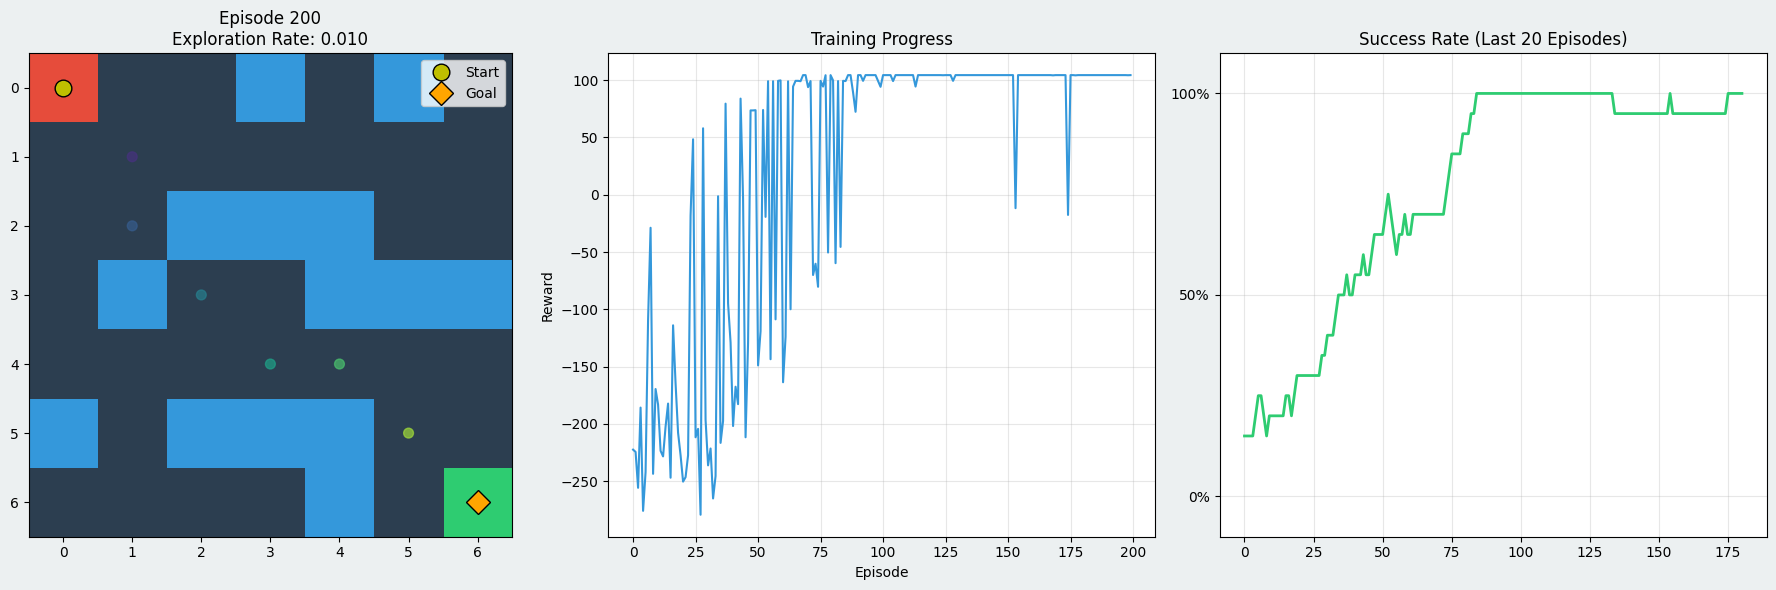

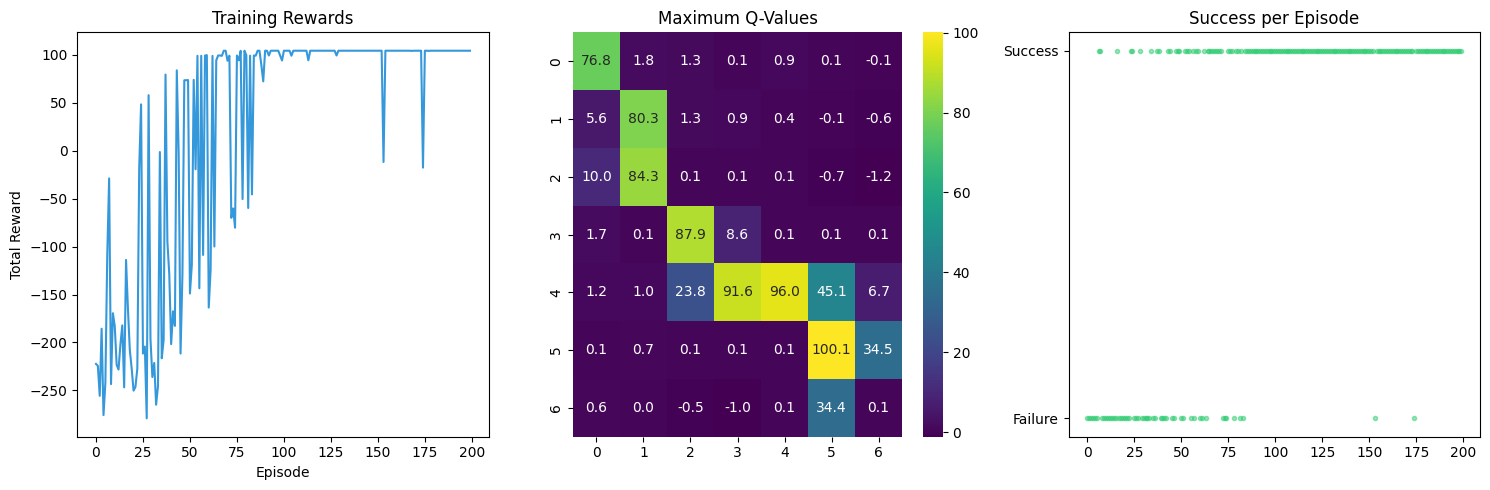

2025-03-28 20:33:17,467 - INFO: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Solve method returning: [(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (4, 4), (5, 5), (6, 6)], Goal reached: True


Training completed! Check final visualizations below.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from IPython.display import display, clear_output, HTML
import time
from collections import deque

# Custom colormap with better contrast
colors = ['#2c3e50', '#3498db', '#e74c3c', '#2ecc71']  # Wall, Path, Start, Goal
cm = LinearSegmentedColormap.from_list("maze_cmap", colors, N=4)

class CreativeMazeSolver:
    def __init__(self, size=7, wall_density=0.3):
        """Initialize with a validated random maze"""
        self.size = size
        self.maze, self.start, self.goal = self.generate_valid_maze(size, wall_density)
        self.q_table = np.random.uniform(low=-0.1, high=0.1, size=(size, size, 8))  # 8 actions
        self.actions = [(-1, 0), (-1, 1), (0, 1), (1, 1),
                        (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.exploration_rate = 1.0
        self.min_exploration = 0.01
        self.decay_rate = 0.995
        self.history = []
        self.fig = None
        self.axes = None
        self._setup_visualization()

    def _setup_visualization(self):
        """Initialize interactive visualization"""
        plt.ioff()
        self.fig, self.axes = plt.subplots(1, 3, figsize=(18, 6),
                                         gridspec_kw={'width_ratios': [1, 1, 1]})
        self.fig.patch.set_facecolor('#ecf0f1')
        plt.ion()

    def generate_valid_maze(self, size, wall_density):
        """Generate maze with guaranteed path using BFS validation"""
        for _ in range(100):  # Max attempts to create valid maze
            maze = np.random.choice([0, 1], size=(size, size),
                                     p=[1-wall_density, wall_density])
            maze[0, 0] = 2  # Start
            maze[size-1, size-1] = 3  # Goal

            # Validate path existence using BFS
            if self._bfs_path_exists(maze, (0,0), (size-1, size-1)):
                return maze, (0,0), (size-1, size-1)
        raise ValueError("Could not generate valid maze after 100 attempts")

    def _bfs_path_exists(self, maze, start, goal):
        """BFS path validation between start and goal"""
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        visited = np.zeros_like(maze, dtype=bool)
        queue = deque([start])
        visited[start] = True

        while queue:
            r, c = queue.popleft()
            if (r, c) == goal:
                return True
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < maze.shape[0] and 0 <= nc < maze.shape[1]:
                    if not visited[nr, nc] and maze[nr, nc] != 1:
                        visited[nr, nc] = True
                        queue.append((nr, nc))
        return False

    def is_valid(self, state):
        """Check if state is valid"""
        r, c = state
        return 0 <= r < self.size and 0 <= c < self.size and self.maze[r, c] != 1

    def step(self, state, action):
        """Take a step with distance-based rewards"""
        r, c = state
        dr, dc = self.actions[action]
        next_state = (r + dr, c + dc)

        if not self.is_valid(next_state):
            return state, -5, False

        if self.maze[next_state] == 3:
            return next_state, 100, True

        # Distance-based reward shaping
        current_dist = abs(r - self.goal[0]) + abs(c - self.goal[1])
        new_dist = abs(next_state[0] - self.goal[0]) + abs(next_state[1] - self.goal[1])
        distance_reward = (current_dist - new_dist) * 0.5

        return next_state, -0.1 + distance_reward, False

    def choose_action(self, state):
        """Epsilon-greedy with adaptive exploration decay"""
        if np.random.random() < self.exploration_rate:
            return np.random.randint(8)
        return np.argmax(self.q_table[state[0], state[1]])

    def train(self, episodes=200):
        """Train with enhanced visualization and adaptive exploration"""
        rewards = []
        success_history = []

        for episode in range(episodes):
            state = self.start
            path = [state]
            total_reward = 0
            done = False
            steps = 0

            while not done and steps < self.size ** 2 * 2:
                action = self.choose_action(state)
                next_state, reward, done = self.step(state, action)

                # Q-learning update
                old_q = self.q_table[state[0], state[1], action]
                next_max = np.max(self.q_table[next_state[0], next_state[1]])
                new_q = (1 - self.learning_rate) * old_q + \
                        self.learning_rate * (reward + self.discount_factor * next_max)
                self.q_table[state[0], state[1], action] = new_q

                state = next_state
                path.append(state)
                total_reward += reward
                steps += 1
                if done: break

            # Adaptive exploration decay
            self.exploration_rate = max(self.min_exploration,
                                            self.exploration_rate * (self.decay_rate ** (episode/10)))

            rewards.append(total_reward)
            success_history.append(1 if done else 0)
            self.history.append(path)

            # Update visualization every 5 episodes
            if episode % 5 == 0 or episode == episodes - 1:
                self._update_visualization(path, rewards, success_history, episode)
                display(self.fig)
                clear_output(wait=True)
                time.sleep(0.05)

        plt.ioff()
        self._show_final_results(rewards, success_history)
        self._create_path_animation()

    def _update_visualization(self, path, rewards, success_history, episode):
        """Update live visualization dashboard"""
        # Clear previous plots
        for ax in self.axes:
            ax.clear()

        # Maze and path visualization
        self.axes[0].imshow(self.maze, cmap=cm, interpolation='none')
        path_array = np.array(path)
        self.axes[0].scatter(path_array[:,1], path_array[:,0], c=range(len(path)),
                                    cmap='viridis', s=50, alpha=0.7)
        self.axes[0].plot(self.start[1], self.start[0], 'yo', markersize=12, markeredgecolor='k', label='Start')
        self.axes[0].plot(self.goal[1], self.goal[0], 'D', color='orange', markersize=12, markeredgecolor='k', label='Goal')
        self.axes[0].set_title(f"Episode {episode+1}\nExploration Rate: {self.exploration_rate:.3f}")
        self.axes[0].legend()

        # Training progress
        self.axes[1].plot(rewards, color='#3498db', label='Total Reward')
        self.axes[1].set_title("Training Progress")
        self.axes[1].set_xlabel("Episode")
        self.axes[1].set_ylabel("Reward")
        self.axes[1].grid(True, alpha=0.3)

        # Success rate
        window_size = max(1, int(len(success_history)/10))
        success_rate = np.convolve(success_history, np.ones(window_size)/window_size, mode='valid')
        self.axes[2].plot(success_rate, color='#2ecc71', lw=2)
        self.axes[2].set_title(f"Success Rate (Last {window_size} Episodes)")
        self.axes[2].set_ylim(-0.1, 1.1)
        self.axes[2].set_yticks([0, 0.5, 1])
        self.axes[2].set_yticklabels(['0%', '50%', '100%'])
        self.axes[2].grid(True, alpha=0.3)

        plt.tight_layout()

    def _show_final_results(self, rewards, success_history):
        """Display final training results"""
        plt.figure(figsize=(15, 5))

        # Reward plot
        plt.subplot(1, 3, 1)
        plt.plot(rewards, color='#3498db')
        plt.title("Training Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")

        # Q-value heatmap
        plt.subplot(1, 3, 2)
        sns.heatmap(np.max(self.q_table, axis=2), cmap='viridis', annot=True, fmt=".1f")
        plt.title("Maximum Q-Values")

        # Success rate
        plt.subplot(1, 3, 3)
        plt.plot(success_history, 'o', markersize=3, alpha=0.5, color='#2ecc71')
        plt.title("Success per Episode")
        plt.yticks([0, 1], ['Failure', 'Success'])

        plt.tight_layout()
        plt.show()

    def _create_path_animation(self):
        """Create and display path animation"""
        path = self.solve()
        if not path or len(path) < 2:
            print("No valid path found for animation")
            return

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(self.maze, cmap=cm, interpolation='none')
        
        line, = ax.plot([], [], 'r-', lw=2)
        point, = ax.plot([], [], 'ro', markersize=10)
        
        def init():
            line.set_data([], [])
            point.set_data([], [])
            return line, point
        
        def animate(i):
            x = [p[1] for p in path[:i+1]]
            y = [p[0] for p in path[:i+1]]
            line.set_data(x, y)
            point.set_data([x[-1]], [y[-1]])  # Corrected to pass lists
            return line, point
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                                    frames=len(path), interval=200, blit=True)
        plt.close()
        display(HTML(ani.to_jshtml()))

    def solve(self):
        """Solve maze with loop prevention"""
        state = self.start
        path = [state]
        visited = set()

        while state != self.goal and len(path) < self.size ** 2:
            action = np.argmax(self.q_table[state[0], state[1]])
            next_state = (state[0] + self.actions[action][0],
                           state[1] + self.actions[action][1])

            if next_state in visited:
                break  # Prevent infinite loops
            if not self.is_valid(next_state):
                break

            path.append(next_state)
            visited.add(next_state)
            state = next_state

        result = path if state == self.goal else None
        print(f"Solve method returning: {result}, Goal reached: {state == self.goal}")
        return result

# Run the enhanced solver
solver = CreativeMazeSolver(size=7, wall_density=0.3)
print("Starting training with validated maze...")
solver.train(episodes=200)
print("Training completed! Check final visualizations below.")